In [2]:
import matplotlib.pyplot as plt
import scipy
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.io import fits
#import lightkurve as lk
import glob
import pickle
import pyphot
from pyphot import unit
from scipy import stats
import emcee
import corner
import pandas as pd
from bisect import bisect_left

import sys
plt.rcParams.update({'font.size': 22})

sys.path.append('../../WD_models/')
from sed_fitter import FitSED

plt.style.use('vedant')

from astropy import constants as c
from astropy import units as u

k = 1.38e-16
h = 6.626e-27

halpha = 6564.61
hbeta = 4862.68
speed_light = 299792458 # m/s
radius_sun = 696340000 # m 
g_sun = 273.95 # m/s
pc_to_m = 3.086e+16
mass_sun = 1.9884e30
newton_G = 6.674e-11

ca2k = 3933

### Load Model Spectra

In [3]:
# Set stellar parameters

mass = 0.5 * c.M_sun
radius = 0.24 * c.R_sun

g = (c.G * mass / radius**2).to(u.cm/u.s**2)
logg = np.log10(g.value)
print(logg)

CAH = -11.3

5.37661514821594


In [4]:
# Load Blouin models

wd_interp = pickle.load(open('blouin/interpwd.pkl', 'rb'))
lib = pyphot.get_library()

n_points = 15000
lamgrid = 10**np.linspace(np.log10(2000), np.log10(99000), n_points)

def get_wd(teff, logg, cah = CAH, wl = lamgrid):
    return 10**wd_interp((logg, teff, cah, np.log10(wl)))

abs_distance = 10

def get_cal_spec_wd(teff, radius, plx, logg = logg, wl = lamgrid, cah = CAH):
    
    distance = 1000/plx
    
    mfl = get_wd(teff, logg, cah = cah, wl = wl)

    radius = radius * radius_sun
    distance = distance * pc_to_m

    solid_angle = 4 * np.pi * (radius / distance) ** 2

    mfl = solid_angle * mfl * 1.0E+23         
    
    return mfl # in jansky

In [56]:
## Archival data for D63 (double-check)

mags = dict(J = 16.518, H = 15.846, Ks = 15.266,
            W1 = 15.946, W2 = 15.633, W3 = 11.862, W4 = 9.230, 
           Pg = 18.562, Pr = 18.2971, Pi = 18.316, Pz = 18.4477, Py = 18.489)

# e_mags = dict(J = 0.134, H = np.nan, Ks = np.nan,
#               W1 = 0.047, W2 = 0.06, W3 = 0.206, W4 = 0.531, NUV = 0.1359, Py = 0.0175,
#              Su = 0.012, Sg = 0.004, Sr = 0.005, Si = 0.005, Sz = 0.012) errors without floor

e_mags = dict(J = 0.126, H = 0.142, Ks = 0.189, 
              W1 = 0.034, W2 = 0.066, W3 = 0.206, W4 = 0.531,
             Pg = 0.01, Pr = 0.015, Pi = 0.0088, Pz = 0.0102, Py = 0.03)

e_mags = dict(J = 0.126, H = 0.142, Ks = 0.189, 
              W1 = 0.034, W2 = 0.066, W3 = 0.206, W4 = 0.531,
             Pg = 0.03, Pr = 0.03, Pi = 0.03, Pz = 0.03, Py = 0.03)

#gaia_plx = np.array((1.0517, 0.1093)) DR2

gaia_plx = np.array((0.423221619076524, 0.09944047)) # EDR3!!!

# pm: 259.5137
# pmra_err 0.06761136
# pmdec_err 0.058017593

gal_coord = [92.13265717422007, 23.682257011111002]

In [57]:
import dustmaps.bayestar
#dustmaps.bayestar.fetch() # if not already downloaded
from dustmaps.bayestar import BayestarQuery

In [58]:
bstar = BayestarQuery()

Loading pixel_info ...
Loading samples ...
Loading best_fit ...
Replacing NaNs in reliable distance estimates ...
Sorting pixel_info ...
Extracting hp_idx_sorted and data_idx at each nside ...
  nside = 64
  nside = 128
  nside = 256
  nside = 512
  nside = 1024
t = 40.100 s
  pix_info:   0.556 s
   samples:  26.954 s
      best:   5.225 s
       nan:   0.183 s
      sort:   7.014 s
       idx:   0.167 s


In [59]:
coords = SkyCoord(l = gal_coord[0] * u.deg, b = gal_coord[1] * u.deg, frame = 'galactic',
                 distance = (1000 / gaia_plx[0]) * u.pc)

In [60]:
coords

<SkyCoord (Galactic): (l, b, distance) in (deg, deg, pc)
    (92.13265717, 23.68225701, 2362.82825575)>

In [61]:
ebv_samples = bstar(coords, mode='samples')

In [62]:
ebv_samples = np.array(ebv_samples).astype(float)

In [63]:
# Empirical extinction coefficients from Yuan et al 2013

ext_R = dict(
    
    NUV = 7.24,
    Su = 4.39,
    Sg = 3.3,
    Sr = 2.31,
    Si = 1.71,
    Sz = 1.29,
    J = 0.72,
    H = 0.46,
    W1 = 0.18,
    W2 = 0.16,
    
    # FIX below
    
    Pg = 3.3,
    Pr = 2.31,
    Pi = 1.71,
    Pz = 1.29,
    Py = 1
)

In [64]:
bands = ['Pg', 'Pr', 'Pi', 'Pz', 'Py']

pyphot_bands = ['PS1_g', 'PS1_r','PS1_i','PS1_z','PS1_y']

ext_Rs = np.array([ext_R[band] for band in bands])

msigma = 1.5 # Sigma of model spectrum

In [65]:
def get_sed_wd(teff, radius, plx, logg = logg, bands = pyphot_bands, to_mag = False, cah = CAH,
              vbands = bands):
    fl = get_cal_spec_wd(teff, radius, plx, logg, cah = CAH) / 1e-23
    wl = lamgrid * unit['AA']
    fl = fl * unit['flam']
    sed = [];    
    
    for i,band in enumerate(bands):
        f = lib[band]
        se = f.get_flux(wl, fl) * 1e-23 #* u.Jy
        sed.append(se.value)
    sed = np.asarray(sed)
    if to_mag:
        sed = -2.5 * np.log10(sed / 3631) #+ 48.60
    return np.ravel(sed)

In [66]:
# Initialize SED -> flux converter

fitsed = FitSED(bands = bands)

initialized with atm_type = H and bands = ['Pg', 'Pr', 'Pi', 'Pz', 'Py']


In [67]:
# Make SED, test WD model is working

raw_sed = np.array([mags[band] for band in bands]).ravel()
e_sed = np.array([e_mags[band] for band in bands]).ravel()

fid_exts = np.median(ebv_samples) * ext_Rs

sed = raw_sed

wls = [fitsed.mean_wl[band] for band in bands]

fluxes = fitsed.mag_to_flux(sed)
e_fluxes = e_sed * fluxes
model_flux = get_sed_wd(6000, 0.37, gaia_plx[0], logg = logg, bands = pyphot_bands)

corr_fluxes = fitsed.mag_to_flux(sed + fid_exts) # Correct fiducial extinction for plots

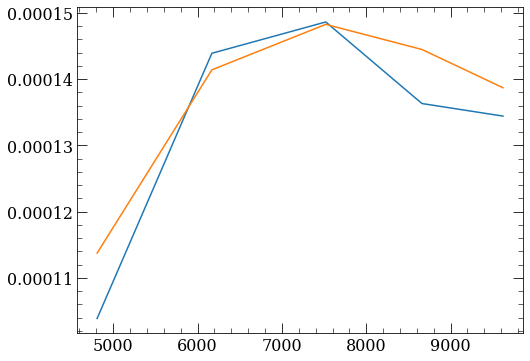

In [68]:
plt.plot(wls, corr_fluxes)
plt.plot(wls, model_flux)

## ** can stop here and move to analyze excess if chains already saved **

In [69]:
def loglik(params):
    
    teff, radius, plx = params
    
    model_sed = get_sed_wd(teff, radius, plx, logg = logg, cah = CAH, to_mag = True)
    
    ebv = np.random.choice(ebv_samples) # Sample random EBV from Bayestar
    exts = ext_Rs * ebv
        
    diff = raw_sed + exts - model_sed
    
    return -0.5 * np.sum(diff**2/e_sed**2)

def logprior(params):
    teff, radius, plx = params
    
    if teff <= 6000 or teff >= 9000:
        return -np.inf
    
    if radius <= 0.005 or radius >= 1:
        return -np.inf
    
    return stats.norm(loc = gaia_plx[0], scale = gaia_plx[1]).logpdf(plx) # paralax 'prior' from Gaia data

def logprob(params):
    
    lp = logprior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    else:
        return lp + loglik(params)

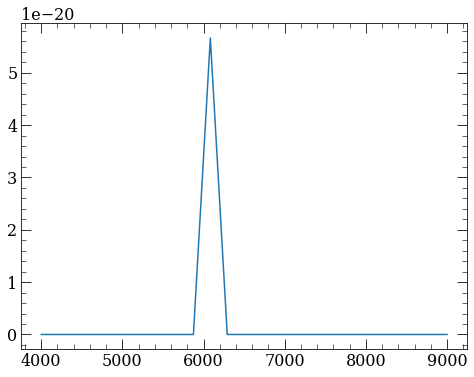

In [70]:
teffs = np.linspace(4000, 9000, 25)
liks = [logprob([teff, 0.37, gaia_plx[0]]) for teff in teffs]

plt.plot(teffs, np.exp(liks))

### Initial Fit to Fix CAH and Logg

### Full MCMC Fit

In [71]:
bestfit = [6500, 0.37, gaia_plx[0]]

In [72]:
ndim, nwalkers = 3, 100

p0 = np.zeros((nwalkers, ndim))

for jj in range(ndim):
    p0[:, jj] = bestfit[jj] + bestfit[jj] * 0.01 * np.random.normal(size = nwalkers) # Initial 1% N-ball
    
paramnames = ['$T_{eff}/K$', '$R/R_\odot$', r'$\varpi/mas$']

In [73]:
filename = "emcee_d63.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logprob, backend = backend)

In [74]:
# Burn-in chains

b0 = sampler.run_mcmc(p0, 100, progress = True);

100%|██████████| 100/100 [05:16<00:00,  3.17s/it]


Text(0.5, 0, 'Steps')

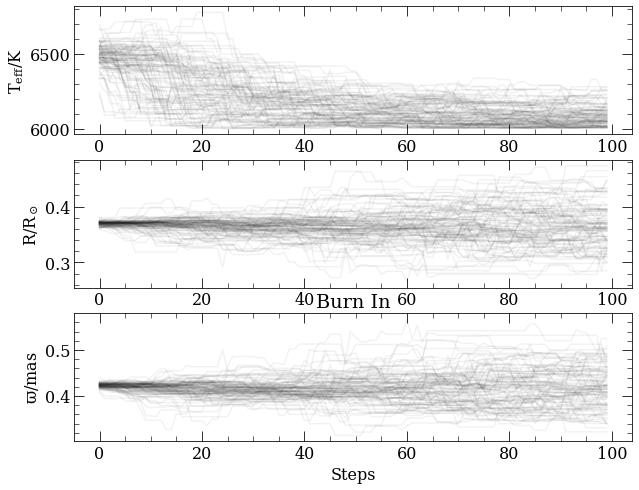

In [75]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
plt.plot(sampler.chain[:, :, 0].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[0])

plt.subplot(312)
plt.plot(sampler.chain[:, :, 1].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[1])


plt.subplot(313)
plt.plot(sampler.chain[:, :, 2].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[2])
plt.title('Burn In')
plt.xlabel('Steps')

In [51]:
# Main production steps

sampler.reset()

b1 = sampler.run_mcmc(b0, 1000, progress = True);

100%|██████████| 1000/1000 [52:23<00:00,  3.14s/it]


In [76]:
print(len(sampler.flatchain))

10000


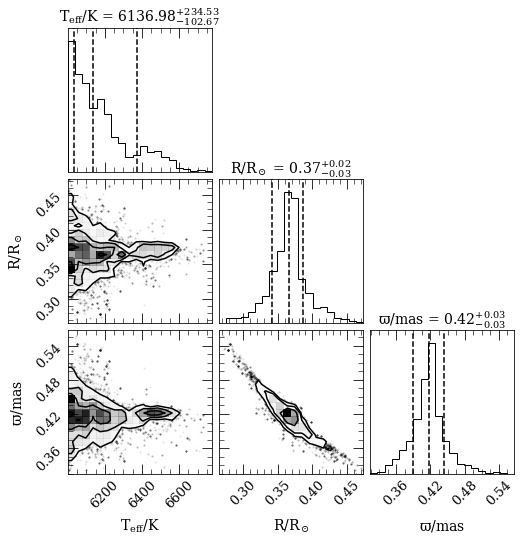

In [77]:
plt.rcParams.update({'font.size': 13})

f = corner.corner(sampler.flatchain, show_titles = True, quantiles = (0.16, 0.5, 0.84),
                 labels = paramnames,
                 title_kwargs = dict(fontsize = 14), label_kwargs = dict(fontsize = 14), fontsize = 14)

#plt.tight_layout()
#lt.subplots_adjust()
#plt.savefig('fig/main_corner.pdf', bbox_inches = 'tight')

In [54]:
#np.savetxt('sed_mcmc/chain.txt', sampler.flatchain)

In [78]:
#np.savetxt('sed_mcmc/logprob.txt', sampler.get_log_prob(flat = True))

In [79]:
radius = sampler.flatchain[:, 1]*c.R_sun
#mass = 0.6 * c.M_sun
#e_mass = 0.15 * c.M_sun
#mass_samples = mass + e_mass * np.random.normal(size = len(sampler.flatchain))
#mass_samples[mass_samples < 0.2 * c.M_sun] = np.median(mass_samples)
mass_samples = c.M_sun * np.random.uniform(0.2, 0.8, size = len(sampler.flatchain))
g = (c.G * mass_samples / radius**2).to(u.cm/u.s**2)
loggs = np.log10(g.value)

allparams = np.vstack((sampler.flatchain.T, loggs)).T

In [80]:
burn = 5000
thin = 2

len(allparams[burn::thin])

2500

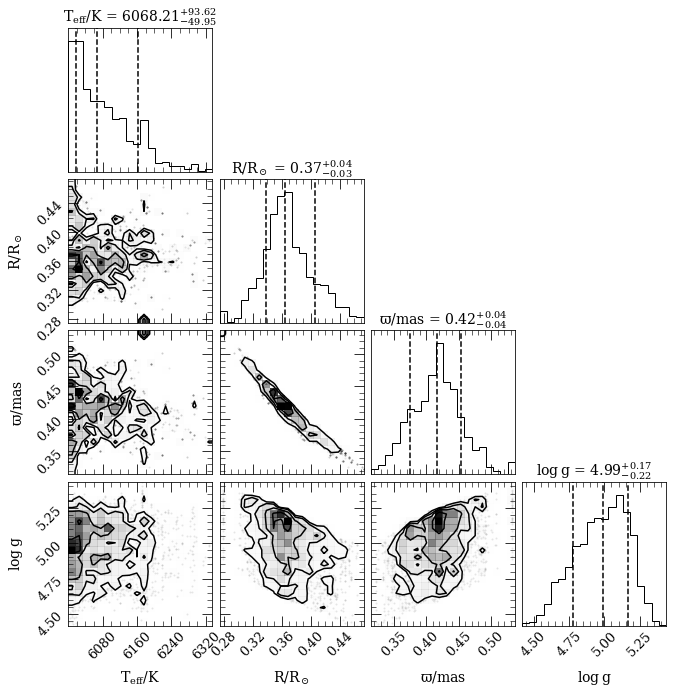

In [81]:
plt.rcParams.update({'font.size': 13})

f = corner.corner(allparams[burn::thin], show_titles = True, quantiles = (0.16, 0.5, 0.84),
                 labels = [r'$T_{eff}/K$', r'$R/R_\odot$', r'$\varpi/mas$', r'$log\,g}$'],
                 title_kwargs = dict(fontsize = 14), label_kwargs = dict(fontsize = 14), fontsize = 14)

#plt.savefig('fig/sedfit_corner.pdf')

In [82]:
#np.savetxt('sed_mcmc/emcee_allparams.dat', allparams)

Text(0.5, 0, 'Steps')

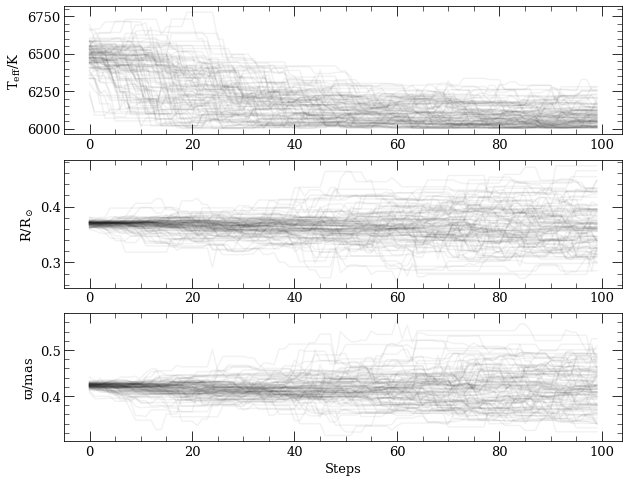

In [83]:
plt.figure(figsize = (10, 8))

plt.subplot(311)
plt.plot(sampler.chain[:, :, 0].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[0])

plt.subplot(312)
plt.plot(sampler.chain[:, :, 1].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[1])


plt.subplot(313)
plt.plot(sampler.chain[:, :, 2].T, color = 'k', alpha = 0.05);
plt.ylabel(paramnames[2])

plt.xlabel('Steps')

In [84]:
bestfit = sampler.flatchain[np.argmax(sampler.get_log_prob(flat = True))]

In [85]:
#np.savetxt('txt/bestfit.txt', bestfit)

Text(0.5, 1.0, 'Initial SED Fit')

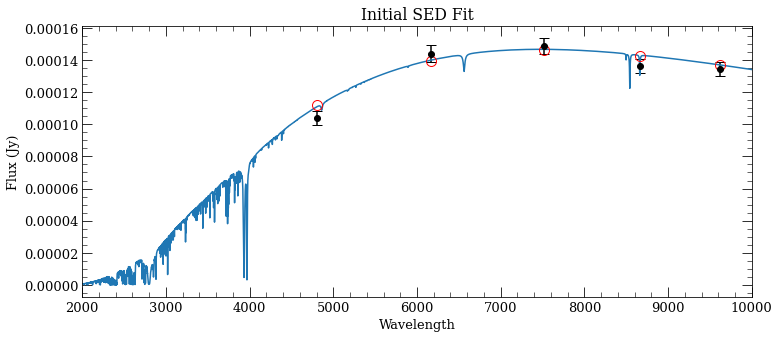

In [86]:
plt.figure(figsize = (12, 5))

plt.errorbar(wls, corr_fluxes, linestyle = 'none', marker = 'o', color = 'k', capsize = 5, yerr = e_fluxes)
plt.plot(lamgrid, get_cal_spec_wd(*bestfit, wl = lamgrid))
plt.plot(wls, get_sed_wd(*bestfit), 'ro', markerfacecolor = 'none', markersize = 10, linewidth = 5)
#plt.yscale('log')
#plt.xscale('log')
plt.xlim(2000, 1e4)

plt.xlabel("Wavelength")
plt.ylabel('Flux (Jy)')

plt.title('Initial SED Fit')

## Analyse Excess

In [87]:
# Once you move to this section of the notebook, do not change anything above. If you do,
# Re-run the whole notebook again. 

In [110]:
#bands = ['NUV', 'Pu', 'Pg', 'Pr', 'Pi', 'Pz', 'J', 'H', 'Ks', 'W1', 'W2', 'W3', 'W4']

bands = ['Pg', 'Pr', 'Pi', 'Pz', 'Py', 'W1', 'W2']

pyphot_bands = ['PS1_g','PS1_r','PS1_i','PS1_z', 'PS1_y',
                'WISE_RSR_W1', 'WISE_RSR_W2']

# FIX BELOW

lcen = dict(Pg = 4700, Pr = 6174, Pi = 7533, Pz = 8781, Py = 10000, J = 12390, 
            H = 16487, W1 = 34655, W2 = 46443 )

fwhms = dict(Pg = 1262, Pr = 1149, Pi = 1238, Pz = 994, Py = 1000, J = 2149, H = 2609, 
           W1 = 6357, W2 = 11073)

In [111]:
fitsed = FitSED(bands = bands)

initialized with atm_type = H and bands = ['Pg', 'Pr', 'Pi', 'Pz', 'Py', 'W1', 'W2']


In [112]:
raw_sed = np.array([mags[band] for band in bands]).ravel()
e_sed = np.array([e_mags[band] for band in bands]).ravel()

exts = np.array([ext_R[band] * np.median(ebv_samples) for band in bands]) # Use fiducial extinction value

sed = raw_sed + exts

wls = np.array([lcen[band] for band in bands])
bws = np.array([fwhms[band] for band in bands])
fluxes = fitsed.mag_to_flux(sed)
e_fluxes = fluxes * e_sed

In [113]:
#bestfit = chain[np.argmax(logprob)]
print(bestfit)

[6.00624509e+03 3.79687682e-01 4.08959088e-01]


In [114]:
wls

array([ 4700,  6174,  7533,  8781, 10000, 34655, 46443])

### Black-Body Model

Text(0.5, 0, 'Wavelength')

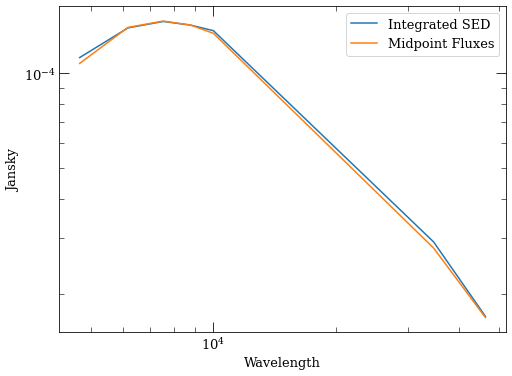

In [115]:
plt.plot(wls, get_sed_wd(*bestfit, logg = logg, bands = pyphot_bands), label = 'Integrated SED')

plt.plot(wls, get_cal_spec_wd(*bestfit, wl = wls), label = 'Midpoint Fluxes')

plt.yscale('log')
plt.xscale('log')

plt.legend()

plt.ylabel("Jansky")
plt.xlabel("Wavelength")

In [116]:
model_flux = get_sed_wd(*bestfit, logg = logg, bands = pyphot_bands)

IR_wls = np.array(wls)
IR_excess = fluxes - model_flux

#np.savetxt('txt/stellar_model.txt', model_flux)
#np.savetxt('txt/wls.txt', wls)

In [117]:
def bb_model(wl, T, R):
    
    R = R * c.R_sun
    D = (1000 / bestfit[2]) * c.pc
    
    nu = c.c / (wl * 1e-10 * u.m)
    
    sa = np.pi * R**2 / D**2
    
    t1 = 2 * c.h * nu**3 / c.c**2
    t2 = np.exp(c.h * nu / (c.k_B * T * u.K)) - 1
    
    return (sa * t1 / t2).to(u.Jy).value

p0 = [1000, 3]

p,cov = scipy.optimize.curve_fit(bb_model, IR_wls, IR_excess, p0 = p0, maxfev = 10000)

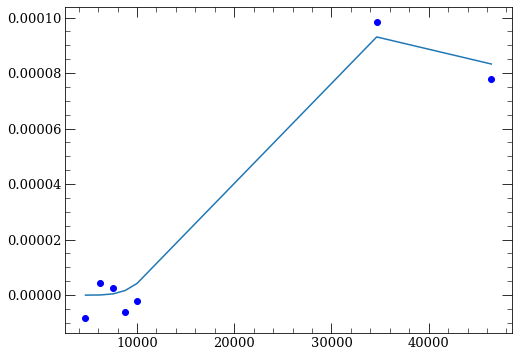

In [118]:
plt.plot(IR_wls, IR_excess, 'bo')
plt.plot(IR_wls, bb_model(IR_wls, p[0], p[1]))

In [119]:
e_teff = np.sqrt(cov[0,0])
e_rad = np.sqrt(cov[1,1])

In [120]:
print(p[0], e_teff)
print(p[1], e_rad)

1514.5097253625454 224.74340149894923
2.3005271961131033 0.46234865649181245


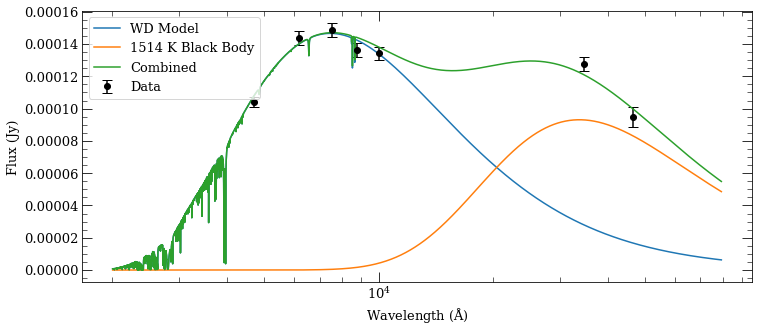

In [121]:
plt.figure(figsize = (12, 5))

plt.errorbar(wls, fluxes, yerr = e_fluxes, color = 'k', linestyle = 'none', marker = 'o', capsize = 5,
            label = 'Data')


# plt.plot(wls, model_flux,color = 'blue', marker = 'o', mfc = 'none', markersize = 15,
#         label = 'DA WD Model')

#plt.yscale('log')
plt.xscale('log')

plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux (Jy)')

grid = np.logspace(3.302, 4.9, 10000)
excess_model = bb_model(grid, p[0], p[1])

plt.plot(grid, get_cal_spec_wd(*bestfit, wl = grid, cah = CAH), color = 'C0', label = 'WD Model')
plt.plot(grid, excess_model, color = 'C1', label = '%i K Black Body' % p[0])
plt.plot(grid, get_cal_spec_wd(*bestfit, wl = grid, cah = CAH) + excess_model, color = 'C2', label = 'Combined')


#plt.ylim(3e-5, 2e-3)
plt.legend()

#plt.savefig('fig/d62_SED.pdf', bbox_inches = 'tight', dpi = 300)

### Jura Flat Disk

In [122]:
from astropy import constants as c
import astropy.units as u
from scipy import integrate
from tqdm import tqdm

In [123]:
def jura_disk(wl, D, i, T_star, R_star, T_in, T_out):
    
    if wl < 1e4:
        return 0
    
    nu = c.c / (wl * 1e-10 * u.m)
    R_star = R_star * c.R_sun
    D = D * c.pc
    T_star = T_star * u.K
    T_in = T_in * u.K
    T_out = T_out * u.K
    
    t1 = 12 * np.pi**(1/3) * R_star**2 * np.cos(i * np.pi / 180) / D**2
    t2 = (2 * c.k_B * T_star / (3 * c.h * nu)) ** (8 / 3)
    t3 = c.h * nu**3 / c.c**2
    
    xmin = c.h * nu / (c.k_B * T_in)
    xmax = c.h * nu / (c.k_B * T_out)
            
#     print(nu)
#     print(xmin, xmax)
#     print(T_out)

#     print(nu)
#     print(T_out)
#     print(T_in)
    
    if T_out < 1 * u.K or T_in < 1 * u.K:
        return 1e20
        
    fn = lambda x: x**(5/3) / (np.exp(x) - 1)
    t4 = integrate.quad(fn, xmin.value, xmax.value)[0]
    
        
    return (t1*t2*t3*t4).to(u.Jy).value

def disk_model(wl, D, i, T_star, R_star, T_in, T_out):
    return np.array([jura_disk(wli, D, i, T_star, R_star, T_in, T_out) for wli in wl]) #* u.Jy

In [124]:
wl_grid = np.logspace(3.2, 5, 100)

In [125]:
# Define initial disk parameters

D = 1000 / bestfit[2] # fixed
i = 0 # fixed
R_star = bestfit[1]
T_star = bestfit[0]

T_in = 1250
T_out = 100 # fixed


disk_sed = disk_model(wl_grid, D, i, T_star, R_star, T_in, T_out)

In [126]:
nmc = 25
prms = [];

for ii in tqdm(range(nmc)):
    def fit_disk(params):
        T_in,T_out = params
        obs_sample = IR_excess + np.random.normal(size = len(IR_excess)) * e_fluxes 
        resid = obs_sample - disk_model(IR_wls, D, i, T_star, R_star, T_in, T_out).ravel()
        return np.sum(resid**2)

    p0 = [np.random.uniform(501, 5000), np.random.uniform(5, 500)] # only fit inner temperature

    res = scipy.optimize.minimize(fit_disk, p0, method = "Powell", bounds = [(501, 5000), (5, 500)])
    prms.append(res.x)

100%|██████████| 25/25 [00:15<00:00,  1.61it/s]


Text(0, 0.5, 'Density')

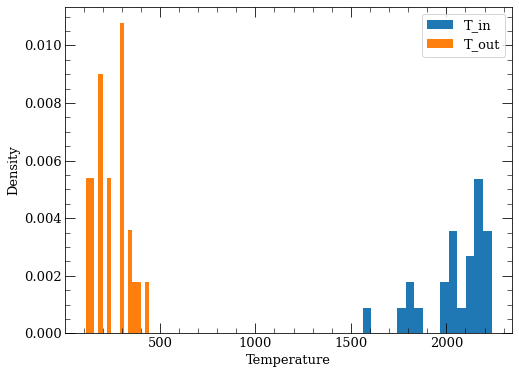

In [127]:
prms = np.array(prms)

plt.hist(prms[:, 0], label = 'T_in', density = True, bins = 15);
plt.hist(prms[:, 1], label = 'T_out', density = True, bins = 15);

plt.legend()

plt.xlabel('Temperature')
plt.ylabel('Density')

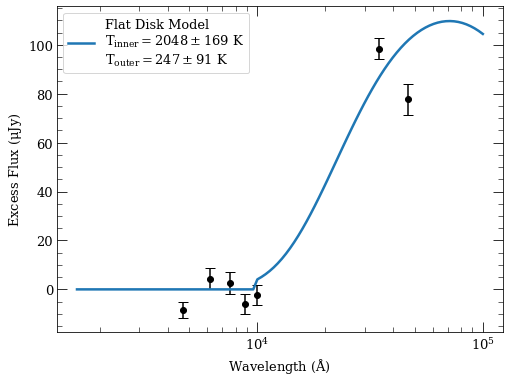

In [128]:
T_in, T_out = np.mean(prms, axis = 0)
e_T_in, e_T_out = np.std(prms, axis = 0)

disk_sed = disk_model(wl_grid, D, i, T_star, R_star, T_in, T_out)
plt.errorbar(IR_wls, IR_excess * 1e6, yerr = e_fluxes * 1e6, color = 'k', 
             linestyle = 'none', marker = 'o', capsize = 5)

plt.plot(wl_grid, disk_sed * 1e6, color = 'C0', linestyle = '-',lw = 2.5,
    label = 'Flat Disk Model\n$T_{inner} = %i \pm %i$ K\n$T_{outer} = %i \pm %i$ K' % (T_in, 
                                                                                       e_T_in, T_out, e_T_out))

#plt.yscale('log')
plt.xscale('log')

plt.ylabel('Excess Flux ($\mu$Jy)')
plt.xlabel('Wavelength ($\AA$)')
plt.legend()

## Combined SED Plot

In [129]:
import matplotlib.ticker as ticker

In [130]:
grid = np.linspace(2000, 10**4, 5000)
grid = np.concatenate((grid,np.linspace(10**4+1, 9.9e4, 5000)))
excess_model = bb_model(grid, p[0], p[1])
disk_excess_model = disk_model(grid, D, i, T_star, R_star, T_in, T_out)

mlsigma = np.diff(grid)[0] * msigma * 2

In [133]:
bandnames = ['g', 'r', 'i', 'z', 'y', 'W1', 'W2']

In [134]:
plt.rcParams.update({'font.size': 18})

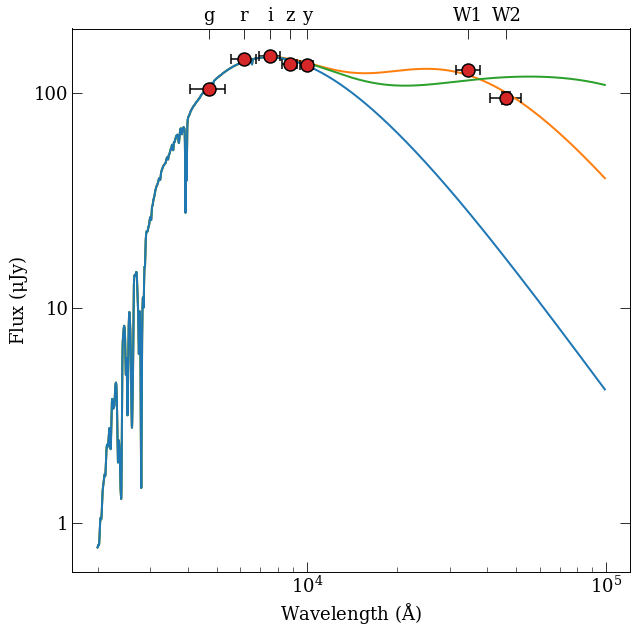

In [140]:
plt.figure(figsize = (10, 10))
plt.yscale('log')
plt.xlabel('Wavelength ($\mathrm{\AA}$)')
plt.ylabel('Flux ($\mu$Jy)')
splinefunc = scipy.interpolate.CubicSpline(wls, fluxes)
lw = 2

#################### PLOT MODELS, SPECTRUM, AND PHOTOMETRY ####################

plt.plot(grid, scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = grid, cah = CAH),mlsigma)\
         + excess_model, color = 'C1', 
         label = 'WD + BB', lw = lw)

plt.plot(grid, scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = grid, cah = CAH), mlsigma)\
         + disk_excess_model, color = 'C2',
         label = 'WD + Flat Disk',
        lw = lw, linestyle = '-')

plt.plot(grid, scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = grid, cah = CAH), mlsigma),
         color = 'C0', label = 'WD Model', lw = lw)

# plt.plot(not_wl, ((not_fl / scipy.ndimage.gaussian_filter1d(not_fl, 100))) * splinefunc(not_wl), 'k', lw = 0.5,
#         label = 'NOT Spectrum')

plt.errorbar(wls, fluxes, yerr = e_fluxes, color = 'tab:red', linestyle = 'none', marker = 'o', capsize = 5,
            label = 'Photometric Data', mew = 1.5, mec = 'k', markersize = 13, ecolor = 'k',
            xerr = bws/2)


#################### FORMAT AND SCALE AXES AND LABELS ####################

ax = plt.gca()
ticks = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x*1e6)) # change to micro-Jansky units
ax.yaxis.set_major_formatter(ticks)
#plt.ylim(1e-5, 4e-3)
handles,labels = ax.get_legend_handles_labels()
# sortidx = np.array([4, 3, 2, 0, 1])
# ax.legend(np.array(handles)[sortidx],
#           np.array(labels)[sortidx],loc = 'lower right', framealpha = 1, fontsize = 16)


#################### INSET ZOOM-IN TO CA DOUBLET ####################

# axins = ax.inset_axes([0.65, 0.65, 0.3, 0.3])
# axins.plot(not_wl, ((not_fl / scipy.ndimage.gaussian_filter1d(not_fl, 100))) * splinefunc(not_wl), 'k', lw = 2)
# axins.plot(not_wl + 1.5, 
#            scipy.ndimage.gaussian_filter1d(get_cal_spec_wd(*bestfit, wl = not_wl,
#                                             cah = CAH), sigma = msigma) + 0.000035,
#                                                    color = 'C0', label = 'WD', lw = 2.5)
# x1, x2, y1, y2 = 3890, 4000, 13e-5, 42e-5
# axins.set_xlim(x1, x2)
# axins.set_ylim(y1, y2)
# axins.set_xticklabels('')
# axins.set_yticklabels('')
# axins.text(0.9, 0.9, 'Ca II H,K', ha = 'right', va = 'top', transform = axins.transAxes)
# ax.indicate_inset_zoom(axins)
ax.set_xscale('log')

#################### BAND NAMES ON TOP ####################

axtop = ax.twiny()
axtop.set_xlim(ax.get_xlim())
axtop.set_xscale('log')
axtop.set_xticks(wls)
axtop.set_xticklabels(bandnames)
axtop.minorticks_off()

#plt.savefig('fig/d62_SED.pdf', bbox_inches = 'tight', dpi = 300)

## SED for JWST ETC

In [102]:
deepir = np.logspace(5, 6, 150)
deepbb = bb_model(deepir, p[0], p[1])
#deepbb = disk_model(deepir, D, i, T_star, R_star, res.x, 500)

In [103]:
approx_spec = get_cal_spec_wd(*bestfit, wl = grid, cah = CAH) + excess_model

In [104]:
approx_spec = np.concatenate((approx_spec, deepbb))
etc_grid = np.concatenate((grid, deepir))

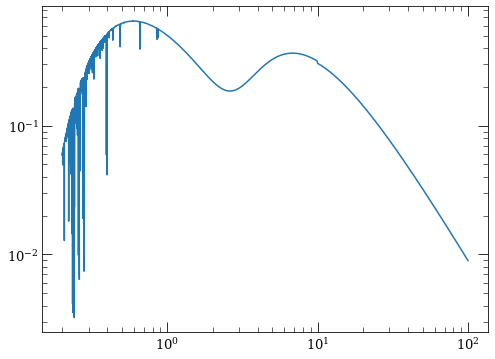

In [105]:
plt.plot(etc_grid/1e4, approx_spec * 1000)
plt.xscale('log')
plt.yscale('log')

In [106]:
etc_spec = np.vstack((etc_grid / 1e4, approx_spec * 1000)).T

In [79]:
np.savetxt('etc_spec.txt', etc_spec)

In [72]:
import pysynphot as psyn

/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/pysynphot/locations.py:46: UserWarning: PYSYN_CDBS is undefined; functionality will be SEVERELY crippled.
  warnings.warn("PYSYN_CDBS is undefined; functionality will be SEVERELY "
/Users/vedantchandra/opt/anaconda3/envs/metalpoor/lib/python3.6/site-packages/pysynphot/locations.py:345: UserWarning: Extinction files not found in extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))


In [73]:
sp = psyn.FileSpectrum('etc_spec.txt')